In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [2]:
DATA_DIR = "/kaggle/input/graddataset"  # Original dataset
TRAIN_DIR = "/kaggle/working/train_data"  # Training data
TEST_DIR = "/kaggle/working/test_data"  # Testing data
IMG_SIZE = (299, 299)  # Required for InceptionV3
BATCH_SIZE = 16
EPOCHS = 10
MAX_IMAGES_PER_CLASS = 16000  # Limit to 16k images per class

In [3]:
def prepare_dataset(data_dir, train_dir, test_dir, max_images_per_class, train_split=0.8):
    # Clear existing directories
    for dir_path in [train_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    # Process each class
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            # Limit images to max_images_per_class
            images = os.listdir(class_path)[:max_images_per_class]
            train_images, test_images = train_test_split(images, train_size=train_split, random_state=42)

            # Create class directories in train and test folders
            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            # Copy images to train and test directories
            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_class_dir, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_class_dir, image))

In [4]:
prepare_dataset(DATA_DIR, TRAIN_DIR, TEST_DIR, MAX_IMAGES_PER_CLASS)

# Step 2: Data Augmentation and Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 46665 images belonging to 4 classes.


In [6]:
test_gen = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Disable shuffle to align predictions with labels
)

Found 11666 images belonging to 4 classes.


In [7]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Fine-tune layers
for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

In [9]:
model = Model(inputs=base_model.input, outputs=predictions)

# Step 4: Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Step 5: Callbacks
checkpoint = ModelCheckpoint(
    filepath=os.path.join("/kaggle/working", "inceptionv3_model_epoch_{epoch:02d}.keras"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [11]:
csv_logger = CSVLogger(os.path.join("/kaggle/working", 'training_log.csv'))

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [12]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, csv_logger, lr_scheduler]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2917/2917 ━━━━━━━━━━━━━━━━━━━━ 1125s 378ms/step - accuracy: 0.6567 - loss: 7.0834 - val_accuracy: 0.7980 - val_loss: 1.2223 - learning_rate: 1.0000e-04
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 1082s 370ms/step - accuracy: 0.7862 - loss: 1.0261 - val_accuracy: 0.8273 - val_loss: 0.5971 - learning_rate: 1.0000e-04
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 1075s 368ms/step - accuracy: 0.8042 - loss: 0.6397 - val_accuracy: 0.8261 - val_loss: 0.5435 - learning_rate: 1.0000e-04
Epoch 4/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 1074s 368ms/step - accuracy: 0.8114 - loss: 0.5730 - val_accuracy: 0.8246 - val_loss: 0.5190 - learning_rate: 1.0000e-04
Epoch 5/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 1074s 367ms/step - accuracy: 0.8247 - loss: 0.5377 - val_accuracy: 0.8478 - val_loss: 0.4715 - learning_rate: 1.0000e-04
Epoch 6/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 1088s 372ms/step - accuracy: 0.8342 - loss: 0.5129 - val_accuracy: 0.8557 - val_loss: 0.4483 - learning_rate: 1.0000e-04
Epoch 7/10
2917/2917 ━━━━━━━━━━━━

In [13]:
model.save(os.path.join("/kaggle/working", "inceptionv3_final_model.keras"))

# Step 7: Evaluate the Model
test_gen.reset()
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.2f}")

730/730 ━━━━━━━━━━━━━━━━━━━━ 215s 294ms/step - accuracy: 0.8032 - loss: 0.5481
Test Accuracy: 0.87


In [14]:
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

730/730 ━━━━━━━━━━━━━━━━━━━━ 223s 298ms/step


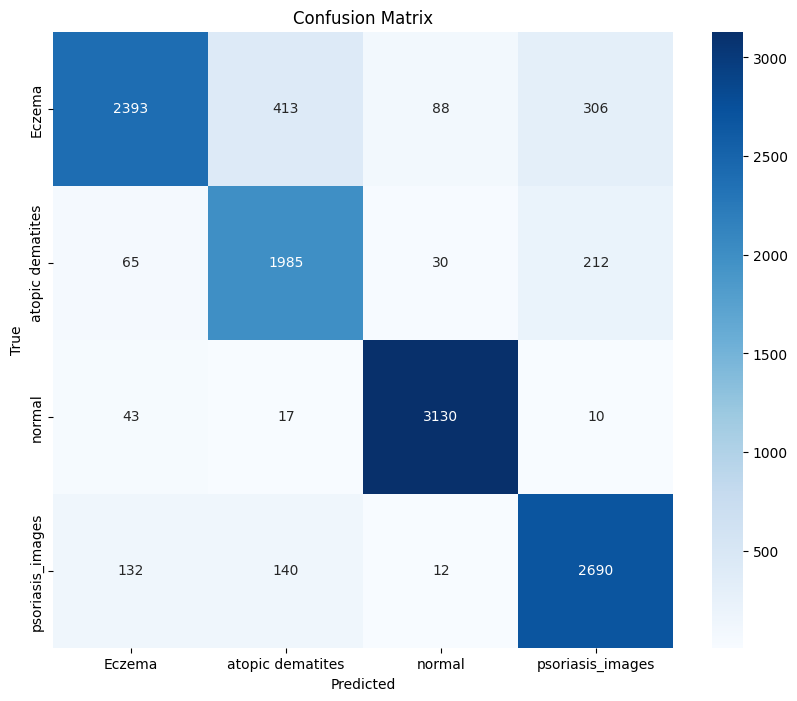

                  precision    recall  f1-score   support

          Eczema       0.91      0.75      0.82      3200
atopic dematites       0.78      0.87      0.82      2292
          normal       0.96      0.98      0.97      3200
psoriasis_images       0.84      0.90      0.87      2974

        accuracy                           0.87     11666
       macro avg       0.87      0.87      0.87     11666
    weighted avg       0.88      0.87      0.87     11666



In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))